In [ ]:
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym

import gym_env
from utils import decision_policy, update_terminal_reward, policy_reval, softmax
from utils_render import plot_decision_prob
from models import SR_IS, SR_TD

In [2]:
# Set the random seed for NumPy
seed = 112233
np.random.seed(seed)

# Hyperparams
reward = -0.1
alpha = 0.2
beta = 1.0
num_steps = 80000
env = "maze-10x10-two-goal"

# For plotting
colors = [1, 9]

# Save dir
save_dir = os.path.join('..', 'figures/')

## Policy Revaluation

### Learn DR

In [ ]:
sr_is = SR_IS(env_name=env, reward=reward, term_reward=reward, alpha=alpha, beta=beta, 
              num_steps=num_steps, policy="softmax", imp_samp=True)

sr = SR_IS(env_name=env, reward=reward, term_reward=reward, alpha=alpha, beta=beta, 
              num_steps=num_steps, policy="softmax", imp_samp=False)

sr_mb = SR_IS(env_name=env, reward=reward, term_reward=reward, alpha=alpha, beta=beta, 
              num_steps=num_steps, policy="softmax", imp_samp=False)

update_terminal_reward(sr_is, loc=0, r=5)
update_terminal_reward(sr, loc=0, r=5)
update_terminal_reward(sr_mb, loc=0, r=5)

In [4]:
sr_is.learn(seed=seed)
sr.learn(seed=seed)

### Get old policy

In [5]:
pii_old_sr_is = decision_policy(sr_is, sr_is.Z)
pii_old_sr = decision_policy(sr, sr.Z)

### Update terminal state rewards and get new policy

In [6]:
update_terminal_reward(sr_is, loc=1, r=10)
V_new, Z_new = policy_reval(sr_is)
pii_new_sr_is = decision_policy(sr_is, Z_new)

update_terminal_reward(sr, loc=1, r=10)
V_new, Z_new = policy_reval(sr)
pii_new_sr = decision_policy(sr, Z_new)

### Plot decision probs at key point

#### SR-IS

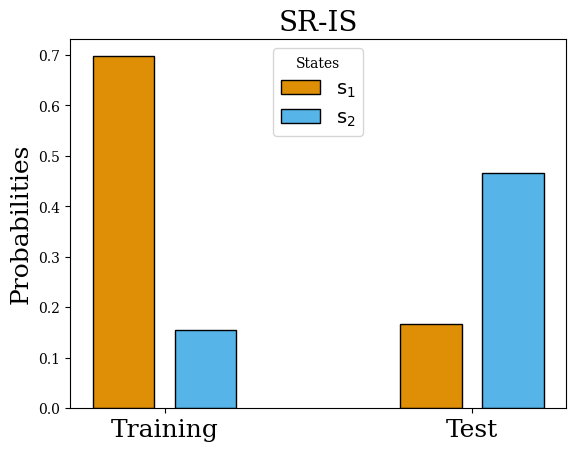

In [7]:
save_path = save_dir + 'policy_reval_sr_is.png'

prob_old = [pii_old_sr_is[28,23], pii_old_sr_is[28,34]]
prob_new = [pii_new_sr_is[28,23], pii_new_sr_is[28,34]]
plot_decision_prob(probs_train=prob_old, probs_test=prob_new, colors=colors, title='SR-IS', leg_loc="upper center", save_path=None)

#### SR

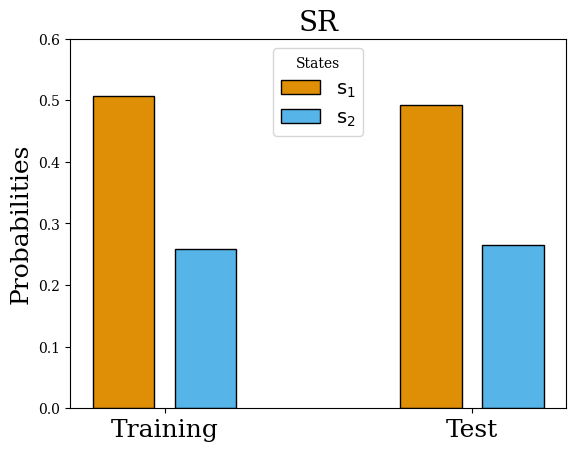

In [8]:
save_path = save_dir + 'policy_reval_sr.png'

prob_old = [pii_old_sr[28,23], pii_old_sr[28,34]]
prob_new = [pii_new_sr[28,23], pii_new_sr[28,34]]
plot_decision_prob(probs_train=prob_old, probs_test=prob_new, colors=colors, title='SR', leg_loc="upper center", save_path=None)

#### SR-MB

In [14]:
np.argwhere(sr_mb.terminals)

array([[ 4],
       [56]])

In [44]:
# sr_mb.DR = sr_mb.gamma * sr_mb.get_D_inv()
sr_mb_r_old = np.full_like(sr_mb.r, fill_value=0)
sr_mb_r_old[4] = 5
sr_mb_r_new = np.copy(sr_mb_r_old)
sr_mb_r_new[56] = 10

I = np.eye(sr_mb.size)
SR_Inv = np.linalg.inv(I-sr_mb.gamma*pii_old_sr)

V_old = SR_Inv @ sr_mb_r_old
V_new = SR_Inv @ sr_mb_r_new

In [45]:
probs_old_sr_mb = softmax(x=np.array([V_old[23], V_old[34]]), temperature=1)
probs_new_sr_mb = softmax(x=np.array([V_new[23], V_new[34]]), temperature=1)

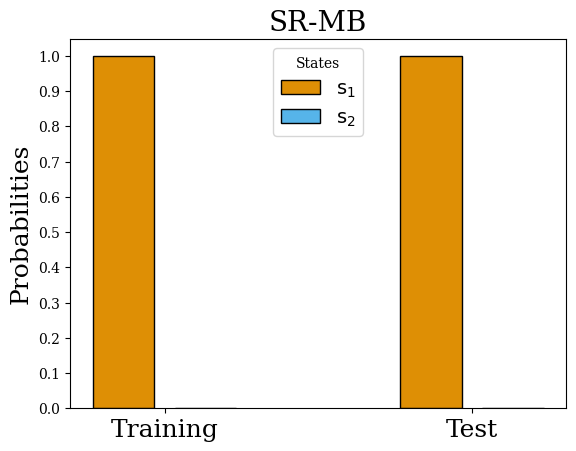

In [46]:
save_path = save_dir + 'policy_reval_sr_mb.png'

plot_decision_prob(probs_train=probs_old_sr_mb, probs_test=probs_new_sr_mb, colors=colors, title='SR-MB', leg_loc="upper center", save_path=None)

In [77]:
def get_map_values(agent, decimals=2):
    map_values = np.full_like(agent.maze, 0.0, dtype=float)
    
    for i in range(agent.maze.shape[0]):
        for j in range(agent.maze.shape[1]):
            if agent.maze[i,j] == '1':
                map_values[i,j] = -np.inf
            else:
                map_values[i,j] = np.round(agent.V[agent.mapping[(i,j)]], decimals=decimals)
    return map_values

import pandas as pd

def print_map_values(agent, decimals=2):
    map_values = get_map_values(agent, decimals)
    
    for row in map_values:
        formatted_row = []
        for val in row:
            if np.isneginf(val):
                formatted_row.append("  -∞ ")
            else:
                formatted_row.append(f"{val:2.{decimals}f}")
        print(" ".join(formatted_row))

In [78]:
print_map_values(sr_is)

  -∞  -8.37   -∞    -∞  -6.95   -∞    -∞  -1.00 0.21 -0.10
-8.46 -8.25 -7.70 -7.21 -6.85 -6.82   -∞  -1.31 -0.93 -0.68
-8.46 -8.27 -7.61 -6.97 -6.27 -6.61   -∞  -1.77   -∞    -∞ 
  -∞  -8.73   -∞    -∞  -5.29   -∞    -∞  -2.25   -∞    -∞ 
  -∞  -9.20   -∞    -∞  -4.68 -4.02 -3.41 -2.82   -∞    -∞ 
  -∞  -9.68   -∞  -5.30 -4.83 -4.06 -3.44 -2.88   -∞    -∞ 
  -∞  -10.20   -∞  -5.73 -5.51   -∞    -∞  -2.38   -∞    -∞ 
-11.15 -10.85   -∞  -6.12 -6.07   -∞  -1.90 -1.91   -∞    -∞ 
-11.30 -11.25   -∞    -∞  -6.22   -∞  -1.72 -1.39 -0.88 0.03
  -∞  -11.36   -∞    -∞  -6.17   -∞    -∞  -0.98 0.03 -0.10
